# 01_summary_statistics.ipynb

In [59]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd
from scipy import stats
import xyzservices.providers as xyz

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_92746/331669241.py:25: DtypeWarning: Columns (133,149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)


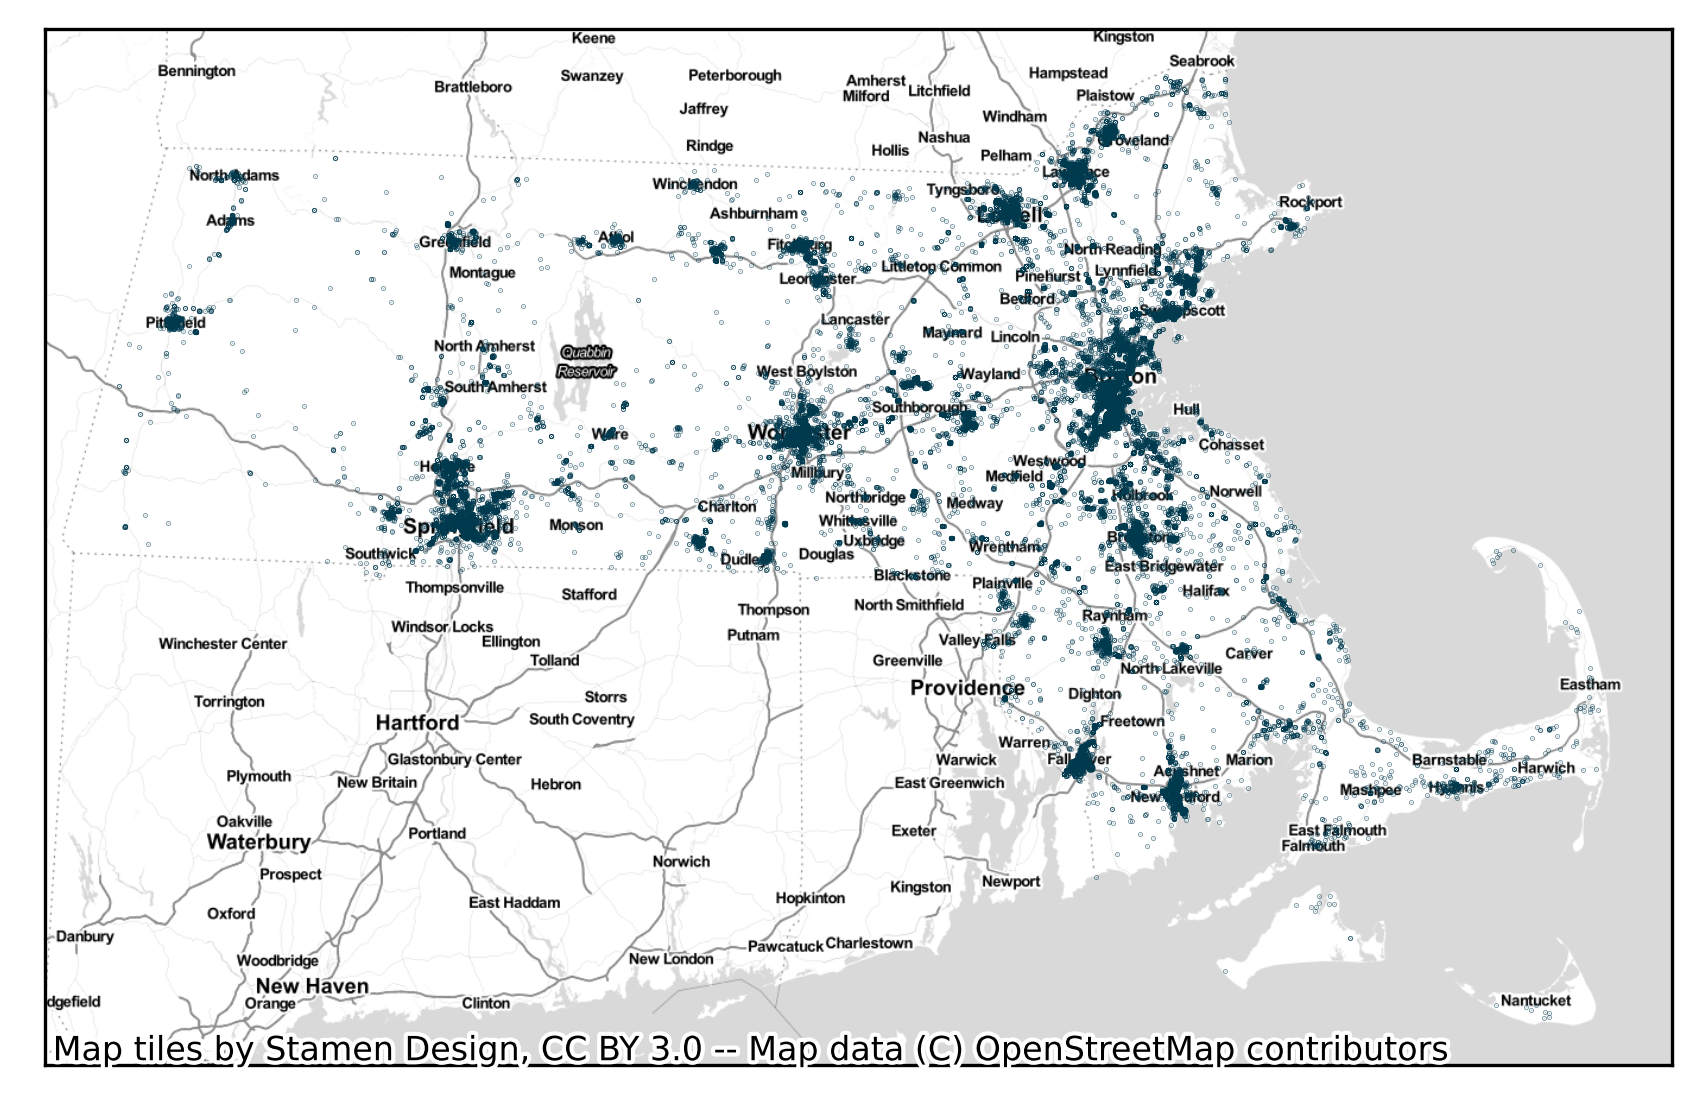

In [60]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05,
                      alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

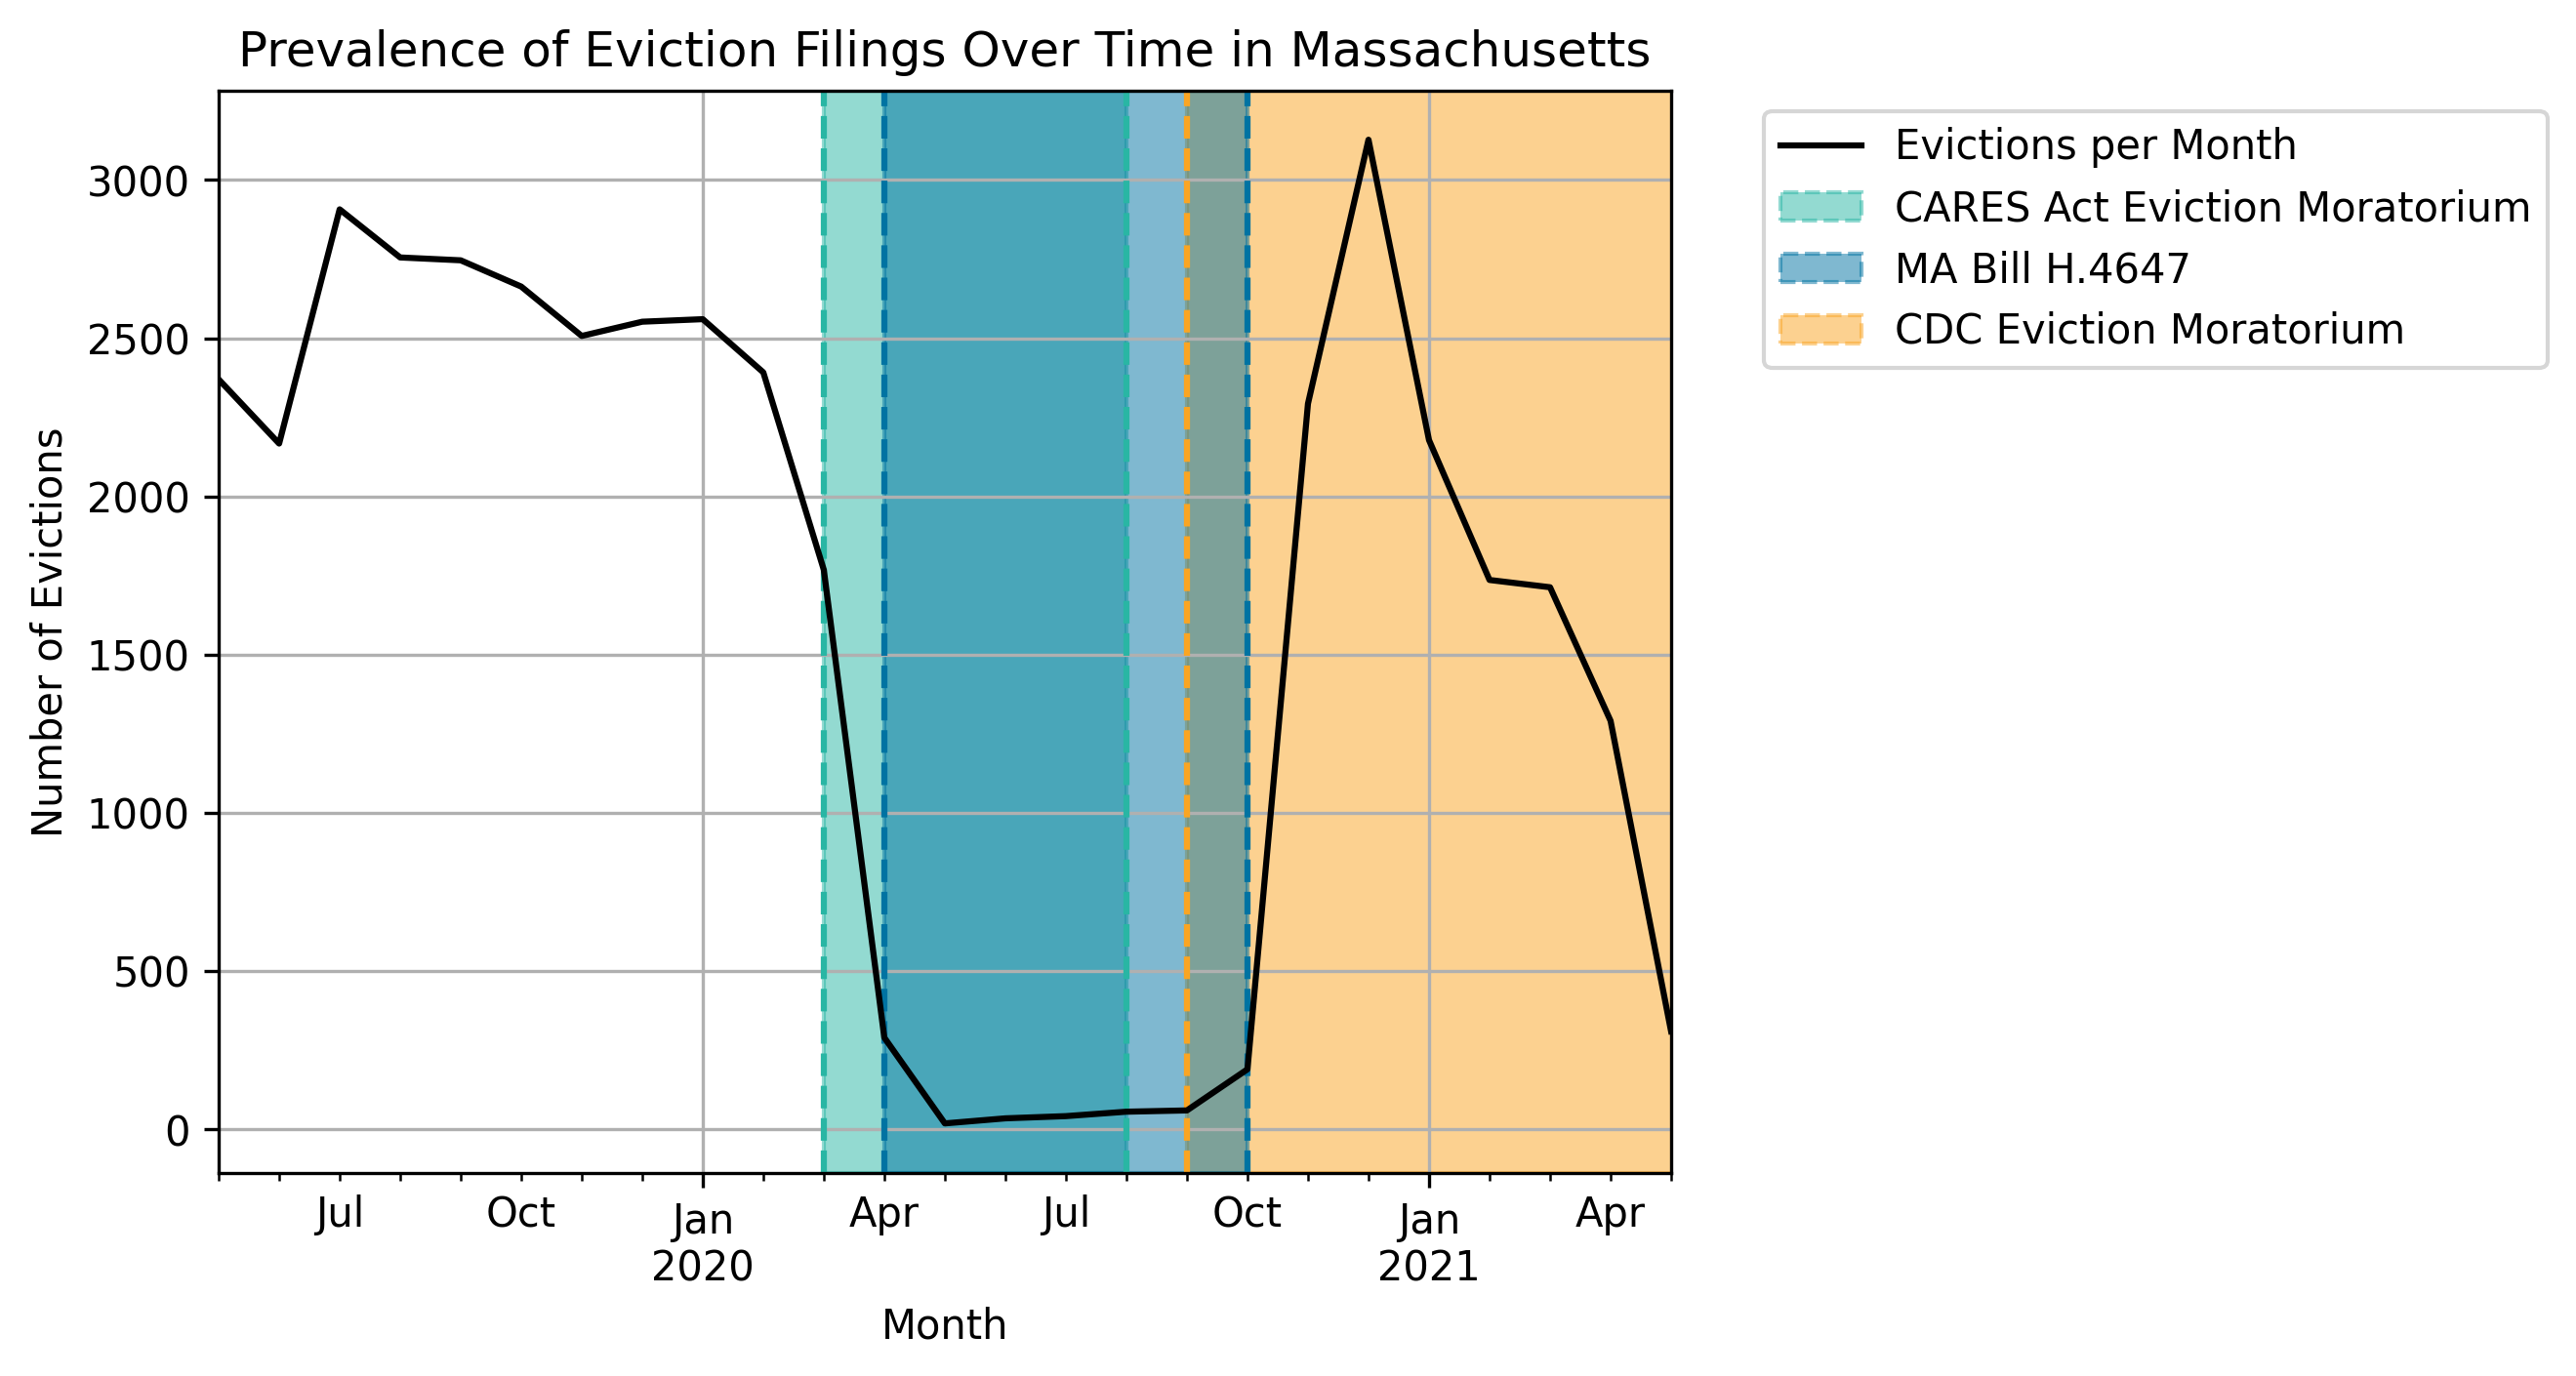

In [61]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Massachusetts")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [62]:
# Master summary statistics function.
def produce_summary_statistics(df: pd.DataFrame, treatment_date_variable: str):
    # Panel A: Case Initiaton
    panel_A_columns = ['for_cause', 'foreclosure', 'no_cause', 'non_payment', 'for_cause_transfer',
                       'foreclosure_transfer',
                       'non_payment_transfer', 'no_cause_transfer']
    origin_columns = ['initiating_action', 'initiating_action', 'initiating_action', 'initiating_action',
                      'initiating_action', 'initiating_action', 'initiating_action', 'initiating_action']
    target_values = ["SP Summons and Complaint - Cause", "SP Summons and Complaint - Foreclosure",
                     "SP Summons and Complaint - No Cause", "SP Summons and Complaint - Non-payment of Rent",
                     "SP Transfer - Cause", "SP Transfer - Foreclosure", "SP Transfer - Non-payment of Rent",
                     "SP Transfer- No Cause"]

    for dummy_column, origin_column, target_value in zip(panel_A_columns, origin_columns, target_values):
        df.loc[:, dummy_column] = np.where(df[origin_column] == target_value, 1, 0)

    panel_A = df[sorted(panel_A_columns)].describe().T
    panel_A = pd.concat([panel_A], keys=["Panel A: Case Initiation"])

    # Panel B: Case Resolution
    panel_B_columns = ['mediated', 'dismissed', 'defaulted', 'heard']
    origin_columns = ['disposition_found', 'disposition_found', 'disposition_found',
                      'disposition_found']
    target_values = ["Mediated", "Dismissed", "Defaulted", "Heard"]

    for dummy_column, origin_column, target_value in zip(panel_B_columns, origin_columns, target_values):
        df.loc[:, dummy_column] = np.where(df[origin_column] == target_value, 1, 0)

    # Add case duration to Panel B.
    panel_B_columns.append('case_duration')
    panel_B = df[sorted(panel_B_columns)].describe().T
    panel_B = pd.concat([panel_B], keys=["Panel B: Case Resolution"])

    # Panel C: Defendant and Plaintiff Characteristics
    panel_C_columns = ['hasAttyD', 'isEntityD', 'hasAttyP', 'isEntityP', 'judgment']
    panel_C = df[sorted(panel_C_columns)].describe().T
    panel_C = pd.concat([panel_C], keys=["Panel C: Defendant and Plaintiff Characteristics"])

    # Panel D: Tax Assessment Records From F.Y. Following Eviction Filing
    panel_D_columns = ['TOTAL_VAL', 'BLDG_VAL', 'LAND_VAL', 'OTHER_VAL', 'UNITS']
    panel_D = df[sorted(panel_D_columns)].describe().T
    panel_D = pd.concat([panel_D], keys=["Panel D: Assessor Records From Post-Filing F.Y."])

    # Panel E: Zestimates Around Last Docket Date
    # Get month of the latest docket date for each row and use to grab Zestimates at different times prior to treatment.
    df.loc[:, treatment_date_variable] = pd.to_datetime(df[treatment_date_variable])
    df.loc[:, 'nan'] = np.nan
    panel_E_columns = []
    for i in range(-5, 4):
        # This column contains the year-month which is i years relative to treatment for each property.
        offset_docket_month = (df[treatment_date_variable] + pd.tseries.offsets.DateOffset(years=i)).dt.strftime('%Y-%m').copy()

        # Some year-months will be outside the range of our data.
        # For instance, we do not have Zestimates 2 years post-treatment for evictions which occurred in 2022. 
        # For these observations, the offset docket month needs to map to the column of nans we created earlier.
        offset_docket_month.loc[~offset_docket_month.isin(df.columns)] = 'nan'

        # Set column accordingly. 
        idx, cols = pd.factorize(offset_docket_month)
        new_col_name = f'zestimate_{i}_years_relative_to_treatment'
        panel_E_columns.append(new_col_name)
        df.loc[:, new_col_name] = df.reindex(cols, axis=1).to_numpy()[np.arange(len(df)), idx]

    panel_E = df[panel_E_columns].describe().T
    panel_E = pd.concat([panel_E], keys=["Panel E: Zestimates Around Last Docket Date"])

    # Concatenate Panels A-E
    summary_statistics = pd.concat([panel_A, panel_B, panel_C, panel_D, panel_E], axis=0)[['50%', 'mean', 'std', 'count']]

    return summary_statistics

In [63]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'file_date'
summary_statistics_unrestricted = produce_summary_statistics(unrestricted_df, treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
display_names = ["For cause", "For cause (transfer)",
                 "Foreclosure", "Foreclosure (transfer)",
                 "No cause", "No cause (transfer)",
                 "Non-payment of rent", "Non-payment of rent (transfer)", "Case duration",
                 "Case defaulted", "Case involuntarily dismissed", "Case heard", "Case mediated",
                 "Defendant has an attorney", "Plaintiff has an attorney", "Defendant is an entity",
                 "Plaintiff is an entity", "Money judgment", "Total property value", "Building value",
                 "Land value", "Other value", "Units", "Five years before latest docket date",
                 "Four years before latest docket date",
                 "Three years before latest docket date", "Two years before latest docket date",
                 "One year before latest docket date", "Latest docket date", "One year after latest docket date",
                 "Two years after latest docket date", "Three years after latest docket date"]
variable_display_names_dict = {key: value for key, value in zip(variable_names, display_names)}

summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N"}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(thousands=",",
                 formatter={'Mean': "{:.2f}",
                            'S.D.': "{:.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

50%  \
Panel                                            Variable                                             
Panel A: Case Initiation                         For cause                                    0.000   
                                                 For cause (transfer)                         0.000   
                                                 Foreclosure                                  0.000   
                                                 Foreclosure (transfer)                       0.000   
                                                 No cause                                     0.000   
                                                 No cause (transfer)                          0.000   
                                                 Non-payment of rent                          1.000   
                                                 Non-payment of rent (transfer)               0.000   
Panel B: Case Resolution                         Case duration                               21.000   
                                                 Case defaulted                               0.000   
                                                 Case involuntarily dismissed                 0.000   
                                                 Case heard                                   0.000   
                                                 Case mediated                                0.000   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                    0.000   
                                                 Plaintiff has an attorney                    1.000   
                                                 Defendant is an entity                       0.000   
                                                 Plaintiff is an entity                       1.000   
                                                 Money judgment                               0.000   
Panel D: Assessor Records From Post-Filing F.Y.  Total property value                    775200.000   
                                                 Building value                          190000.000   
                                                 Land value                                2600.000   
                                                 Other value                            1067000.000   
                                                 Units                                        1.000   
Panel E: Zestimates Around Last Docket Date      Five years before latest docket date    213270.600   
                                                 Four years before latest docket date    225065.750   
                                                 Three years before latest docket date   240097.375   
                                                 Two years before latest docket date     259176.000   
                                                 One year before latest docket date      278722.250   
                                                 Latest docket date                      305144.000   
                                                 One year after latest docket date       347550.000   
                                                 Two years after latest docket date      393900.000   
                                                 Three years after latest docket date    414600.000   

                                                                                                Mean  \
Panel                                            Variable                                              
Panel A: Case Initiation                         For cause                              1.158200e-01   
                                                 For cause (transfer)                   6.334864e-03   
                                                 Foreclosure                            2.010951e-02   
                                                 Foreclosure (transfer)  

In [64]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)

# Separate into treatment and control groups.
restricted_df_treatment = restricted_df.loc[restricted_df['judgment_for_plaintiff'] == 1, :].copy()
restricted_df_control = restricted_df.loc[restricted_df['judgment_for_plaintiff'] == 0, :].copy()

# Produce summary statistics for treatment group.
summary_statistics_treatment = produce_summary_statistics(restricted_df_treatment, treatment_date_variable=treatment_date_variable).drop(columns='std')
summary_statistics_treatment = pd.concat({"Cases Won by Plaintiff": summary_statistics_treatment}, axis=1,
                                         names=["", ""])

# Produce summary statistics for control group. 
summary_statistics_control = produce_summary_statistics(restricted_df_control, treatment_date_variable=treatment_date_variable).drop(columns='std')
summary_statistics_control = pd.concat({"Cases Won by Defendant": summary_statistics_control}, axis=1, names=["", ""])

# Combine tables.
summary_statistics_restricted = pd.concat([summary_statistics_control, summary_statistics_treatment], axis=1)

# Rename rows.
summary_statistics_restricted = summary_statistics_restricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_restricted.index = summary_statistics_restricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N"}
summary_statistics_restricted = summary_statistics_restricted.rename(columns=column_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (summary_statistics_restricted
         .style
         .format(thousands=",", formatter={('Cases Won by Defendant', 'Mean'): "{:.2f}",

                                           ('Cases Won by Defendant', 'N'): "{:.0f}",
                                           ('Cases Won by Plaintiff', 'Mean'): "{:.2f}",

                                           ('Cases Won by Plaintiff', 'N'): "{:.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data",
                   multicol_align="c")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_restricted

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_92746/2978603401.py:2: DtypeWarning: Columns (149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)


Cases Won by Defendant  \
                                                                                                          50%   
Panel                                            Variable                                                       
Panel A: Case Initiation                         For cause                                                0.0   
                                                 For cause (transfer)                                     0.0   
                                                 Foreclosure                                              0.0   
                                                 Foreclosure (transfer)                                   0.0   
                                                 No cause                                                 0.0   
                                                 No cause (transfer)                                      0.0   
                                                 Non-payment of rent                                      1.0   
                                                 Non-payment of rent (transfer)                           0.0   
Panel B: Case Resolution                         Case duration                                           61.0   
                                                 Case defaulted                                           0.0   
                                                 Case involuntarily dismissed                             1.0   
                                                 Case heard                                               0.0   
                                                 Case mediated                                            0.0   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney                                0.0   
                                                 Plaintiff has an attorney                                1.0   
                                                 Defendant is an entity                                   0.0   
                                                 Plaintiff is an entity                                   1.0   
                                                 Money judgment                                           0.0   
Panel D: Assessor Records From Post-Filing F.Y.  Total property value                                641200.0   
                                                 Building value                                      169600.0   
                                                 Land value                                            1100.0   
                                                 Other value                                         823450.0   
                                                 Units                                                    2.0   
Panel E: Zestimates Around Last Docket Date      Five years before latest docket date                185330.5   
                                                 Four years before latest docket date                195892.5   
                                                 Three years before latest docket date               210030.0   
                                                 Two years before latest docket date                 223501.0   
                                                 One year before latest docket date                  240000.0   
                                                 Latest docket date                                  270184.0   
                                                 One year after latest docket date                   317500.0   
                                                 Two years after latest docket date                  348300.0   
                                                 Three years after latest docket date                363650.0   

                                                                                                      \
                           

Limiting sample to 15994 cases for which we observe the file_date.
Limiting sample to 3298 evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.
Limiting the sample to 319803 evictions which are observed during every month from treatment-relative month -12 to treatment-relative month 24.


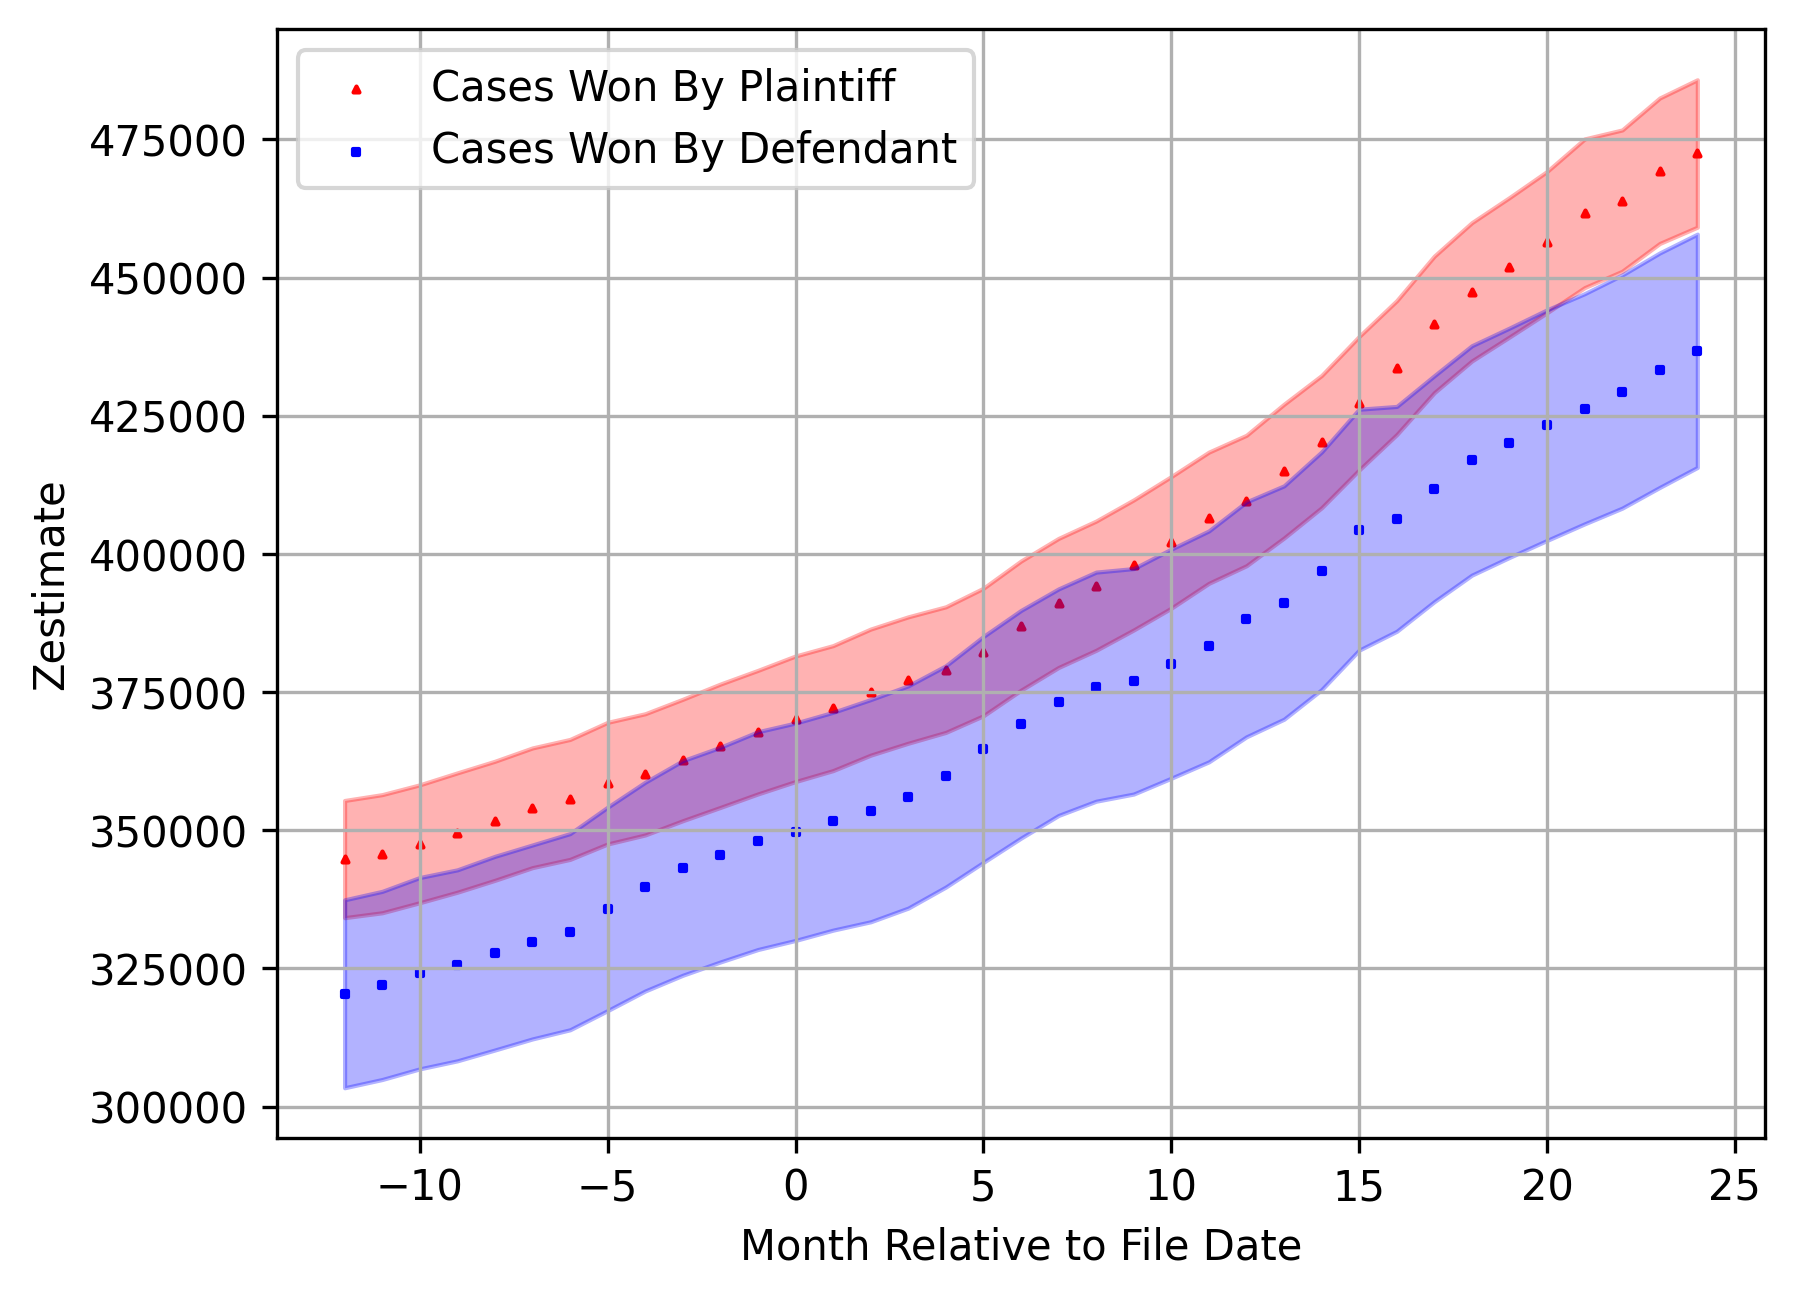

In [65]:
# Plot path of the outcome variable in the treated group and the control group.

# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
restricted_df = restricted_df.dropna(subset=treatment_date_variable)
print(f"Limiting sample to {len(restricted_df)} cases for which we observe the {treatment_date_variable}.")

# Store a list of column names containing Zestimates.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]

# Create dictionaries to map between string representation and integer representation of each month.
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

# Drop rows for which we are missing any Zestimates.
has_all_zestimates_mask = restricted_df[value_vars].notna().all(axis=1)
print(f"Limiting sample to {has_all_zestimates_mask.sum()} evictions for which we observe Zestimates at every month "
      "from 2012-12 to 2022-12.")
restricted_df = restricted_df.loc[has_all_zestimates_mask, :]

# Reshape from wide to long.
restricted_df = pd.melt(restricted_df,
                        id_vars=['case_number', treatment_date_variable, 'judgment_for_plaintiff'],
                        value_vars=value_vars, var_name='month', value_name='zestimate')
restricted_df = restricted_df.sort_values(by=['case_number', 'month'])

# Get 'first treated' date for each observation.
restricted_df.loc[:, treatment_date_variable] = pd.to_datetime(restricted_df[treatment_date_variable]).dt.strftime('%Y-%m')

# Convert months from string format to integer format.
restricted_df.loc[:, 'month'] = restricted_df['month'].replace(month_to_int_dictionary)
restricted_df.loc[:, treatment_date_variable] = restricted_df[treatment_date_variable].replace(month_to_int_dictionary)

# Generate month relative to treatment.
restricted_df.loc[:, 'month_relative_to_treatment'] = ((restricted_df['month'] - restricted_df[treatment_date_variable])
                                                       .astype(int))


# Keep only rows corresponding to cases which are actually observed during the months (relative to treatment) that we care about.
def check_if_time_periods_observed(s: pd.Series, start: int, end: int):
    values = pd.Series(range(start, end + 1))
    check = values.isin(s)
    return check.all()


start_month_relative_to_treatment = -12
end_month_relative_to_treatment = 24
valid_case_numbers = (restricted_df
                      .groupby('case_number')['month_relative_to_treatment']
                      .apply(lambda col: check_if_time_periods_observed(col, start_month_relative_to_treatment,
                                                                        end_month_relative_to_treatment)))
valid_case_numbers = valid_case_numbers[valid_case_numbers].index
valid_case_numbers_mask = restricted_df['case_number'].isin(valid_case_numbers)
print(f"Limiting the sample to {valid_case_numbers_mask.sum()} evictions which are observed "
      f"during every month from treatment-relative month {start_month_relative_to_treatment} to treatment-relative month "
      f"{end_month_relative_to_treatment}.")
restricted_df = restricted_df.loc[valid_case_numbers_mask, :]

# Aggregate by treatment-relative month and treatment status.
restricted_df = (restricted_df.groupby(['month_relative_to_treatment', 'judgment_for_plaintiff'])['zestimate']
                 .agg([np.mean, np.std, 'count'])
                 )
restricted_df.loc[:, 'se'] = restricted_df['std'] / np.sqrt(restricted_df['count'])
restricted_df.loc[:, 'y_upper'] = restricted_df['mean'] + 1.96 * restricted_df['se']
restricted_df.loc[:, 'y_lower'] = restricted_df['mean'] - 1.96 * restricted_df['se']

# Separate into control and treatment group
treated_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 1), :].reset_index()
control_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 0), :].reset_index()

# Plot event study-style plot of trends in Zestimates.
fig, ax = plt.subplots()
if treatment_date_variable == 'file_date':
    ax.set_xlabel("Month Relative to File Date")
elif treatment_date_variable == 'latest_docket_date':
    ax.set_xlabel("Month Relative to Latest Docket Date")
else:
    raise ValueError("Invalid treatment_date_variable.")
ax.set_ylabel("Zestimate")
for dataset, color, marker, label in zip([treated_units, control_units],
                                         ['red', 'blue'],
                                         ["^", "s"],
                                         ["Cases Won By Plaintiff",
                                          "Cases Won By Defendant"]):
    x = dataset['month_relative_to_treatment'].values
    y = dataset['mean'].values
    y_upper = dataset['y_upper'].values
    y_lower = dataset['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax=ax,
                                                     x=x,
                                                     y=y,
                                                     y_upper=y_upper,
                                                     y_lower=y_lower,
                                                     label=label,
                                                     point_color=color,
                                                     marker=marker,
                                                     error_color=color,
                                                     error_opacity=0.3)

ax.legend()
ax.grid(True)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates.png"))


